In [6]:
import pandas as pd
import numpy as np
import requests
import re
from datetime import datetime
from typing import Union, Iterable
import matplotlib.pyplot as plt
import os
import time
import seaborn as sns
from bs4 import BeautifulSoup

In [3]:
url = 'https://www.biznesradar.pl/akcjonariat/KETY'
data = pd.read_html(url)

# Creating Stock Class which will allow to scrap data from Biznesradar

In [55]:
def convert_date(date: str) -> str:

        m = re.match(r"\d{4}/Q\d|\d{4}", date)
        if not m:
            return datetime.today().strftime('%Y%m%d')
        else:
            return m.group().replace("/", "")

def convert_column_vals(val: Union[int, str, float]) -> float:
    
    if isinstance(val, (int, float)):
        return float(val)
    
    regex = re.compile(r'-?[0-9(. )?]+')
    curr = regex.match(val)
    
    if curr:
        return float(re.sub(r'\s', "", curr.group()))
    
    return 0.0

class Stock():
    """
    Uzupelnic
    """
    
    def __init__(self, stock: str = "", period : str = 'Q', get_data: bool = False):
        
        self.site_url = 'https://www.biznesradar.pl' ## Link do strony Biznesradar.pl
        self.urls = ['https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/',
             'https://www.biznesradar.pl/raporty-finansowe-bilans/',
             'https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/',
             'https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/',
             'https://www.biznesradar.pl/wskazniki-rentownosci/',
             'https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/',
             'https://www.biznesradar.pl/wskazniki-zadluzenia/',
             'https://www.biznesradar.pl/wskazniki-plynnosci/',
             'https://www.biznesradar.pl/wskazniki-aktywnosci/',
             'https://www.biznesradar.pl/dywidenda/'] ## List to store all used urls
        
        self.datas = {} ## Dictionary to store all date scrapped from site  D[url] = DataFrame
        self.summary = {} ## Dictionary to store basic information about stock - gets updated by get_stock_summary()
        self.ticker = ""
        self.market = ""
        
        self.stock = stock
        self.period = period
        
        self.update_url(self.period)
        self.info = self.get_stock_summary()
        self.stock_price = self.get_stock_data()
        
        if get_data:
            self.get_data()
    
    def update_url(self, period) -> None:
        
        self.period = period
        
        for i in range(len(self.urls)):
            
            self.urls[i] += self.stock
            
        for i in range(3):
            
            if self.urls[i].endswith(",Q") or self.urls[i].endswith(",Y"):
                self.urls[i][-1] = self.period
            else:
                self.urls[i] += f",{self.period}"
        
    def get_stock_summary(self) -> None:
        
        page = requests.get(self.site_url + '/notowania/' + self.stock) 
        soup = BeautifulSoup(page.content, 'html.parser')
        
        self.market = soup.find('div', attrs = {'class': 'profile_financialmarket'}).text.split()[0]
        self.ticker = soup.find('div', class_ = "textseparatorfirst").text[:-1]
    
        table_info = soup.find('div', attrs = {"class":"box-left"})
        
        for x in zip(table_info.find_all("th"), table_info.find_all("td")):
            self.summary[x[0].text.strip(":")] = x[1].text.strip("\n")
        
        self.summary['Ticker'] = self.ticker
        self.summary['Market'] = self.market
    

    def get_data(self) -> pd.DataFrame: # Create DataFrames based on stock name 
        
        if self.stock:
            
            for url in self.urls:
                
                *_, sub_url, ticker = url.split("/")

                time.sleep(1)
                
                try:
                    df = pd.read_html(url)

                except: # in case of not finding any table create empty DataFrame Object
                    df = pd.DataFrame() 

                ## Handle a case when we want to extract data from /dywidenda
                if sub_url.lower() == "dywidenda":

                    if len(df) <= 2: # Stock doesn't pay dividend so we doens't create DataFrame
                        continue

                    data = df[0].fillna(0)   
                    data.sort_values(by="wypłata za rok", inplace = True)
                    data.set_index("wypłata za rok", inplace = True)
                    data = data.iloc[:,1:3].applymap(convert_column_vals, "ignore")

                    self.datas[url] = data

                for i in range(len(df)):

                    ## replaceing missing data with 0
                    data = df[i].fillna(0)

                    ## Check tables only with first column named "Unnamed: 0" - These are the only tables which we are interesting in
                    if data.columns[0] == "Unnamed: 0":
                        
                        data = data.T.iloc[:-1,:] ## Transpose data so that the dates will be indexes
                        
                        ## Creating new Index Object.
                        
                        if data.iloc[0,0] == "Data publikacji":
                            index = pd.to_datetime(data.iloc[1:,0]).rename("Data")
                            quarter_date = pd.to_datetime(data.index[1:].map(convert_date))
                          
                        else:
                            index = pd.to_datetime(data.index[1:].map(convert_date)).rename("Data")
                        
                        ## Creating new column object from first row of data 
                        columns = data.iloc[0,:]
                        columns.name = ""
                        
                        ## Removing first row in data which
                        data = pd.DataFrame(data.iloc[1:,:])
                        
                        ## Setting new index and columns
                        data.columns = columns
                        data.index = index
                        
                        ## Converting all values of type str to float
                        data = data.applymap(convert_column_vals, "ignore") ## Convert all columns values to float
                       
                        if ticker[-1] in ["Q", "Y"]:
                            diff = 0
                            if len(data) != len(quarter_date):
                                diff = len(quarter_date) - len(data)
                            data['Data publikacji'] = quarter_date[diff:]
                            data.rename(columns={'Data publikacji': 'Data kwartału'}, inplace = True)
                        
                        self.datas[url] = data

                        

    def generate_excel(self, path: str = os.getcwd(), subs: Iterable[str] = []) -> None:  
        
        '''
        Save selected data to excel file
        
        Parameters
        ----------
        path : str
            Path where excel files will be stored. Default directory is current directory 
        subs: Iterable[str]
            List of links to be stored
            
        Returns
        -------
        None
        
        '''
        
        if not subs:
            subs = self.urls
        
        writer = pd.ExcelWriter(f"{path}\\{self.stock},{self.period}.xlsx", engine='xlsxwriter')

        for url in subs:
            
            *_, sub_url, ticker = url.split("/")

            data = self.D[url]

            try:
                data.to_excel(writer, sheet_name = sub_url[:31])
                
            except:

                continue

        writer.save()
    
    def get_stock_data(self) -> pd.DataFrame:
        
        '''
        Extract stock history from file
        
        Creates DataFrame object and return it
        
        '''
        filename = f'{self.market}/{self.ticker.lower()}.txt'
        print (filename)
        with open(filename, 'r') as f:
            data = pd.read_csv(f)
            
        data_to_del = ['<TICKER>', '<DATE>', '<PER>', '<TIME>', '<OPENINT>']
        
        index = pd.to_datetime(data['<DATE>'], format = "%Y%m%d")
        data.index = index
        data.index.name = "DATA"
        data.drop(columns = data_to_del, inplace = True)
        data.columns = data.columns.str.replace(r"<|>", "", regex = True).str.lower()
        
        return data
    
    def plot_price_chart(self, first = None, last = None, plot_type = "line"):
        
        if not first:
            first = self.stock_price.index[0]
        if not last:
            last  = self.stock_price.index[-1]
        plt.figure(figsize = (20, 6))
        sns.lineplot(data=self.stock_price[first:last], x = self.stock_price.index, y = 'close')
        plt.show()
    

    def __str__ (self):
        res = ''
        for k, v in self.info.items():
            res += f"{k}:{v}" + "\n"
        return res
    
    def __repr__(self):
        
        return str(self.__class__) + ' Stock: ' + self.__dict__['stock'] + " Ticker: " + self.ticker
        

In [56]:
test2 = Stock("KETY", period = "Q")
test2.get_data()

GPW/kty.txt


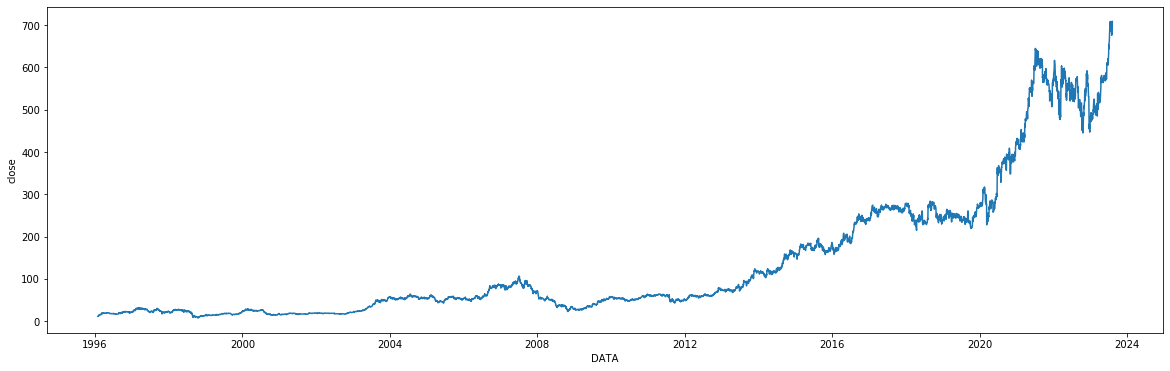

In [57]:
test2.plot_price_chart()

In [58]:
test2.urls

['https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/KETY,Q',
 'https://www.biznesradar.pl/raporty-finansowe-bilans/KETY,Q',
 'https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/KETY,Q',
 'https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/KETY',
 'https://www.biznesradar.pl/wskazniki-rentownosci/KETY',
 'https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/KETY',
 'https://www.biznesradar.pl/wskazniki-zadluzenia/KETY',
 'https://www.biznesradar.pl/wskazniki-plynnosci/KETY',
 'https://www.biznesradar.pl/wskazniki-aktywnosci/KETY',
 'https://www.biznesradar.pl/dywidenda/KETY']

In [62]:
test2.datas[test2.urls[2]]

,Data kwartału,Przepływy pieniężne z działalności operacyjnej,Amortyzacja,Przepływy pieniężne z działalności inwestycyjnej,CAPEX (niematerialne i rzeczowe),Przepływy pieniężne z działalności finansowej,Emisja akcji,Dywidenda,Skup akcji,Płatności z tytułu umów leasingu,Przepływy pieniężne razem,Free Cash Flow
Data,,,,,,,,,,,,
2005-05-11,2005-01-01,22552.0,8514.0,-28964.0,29510.0,10669.0,0.0,0.0,0.0,0.0,4257.0,-6958.0
2005-08-02,2005-04-01,38805.0,9180.0,-17036.0,17469.0,-30651.0,0.0,0.0,0.0,0.0,-8882.0,21336.0
2005-11-08,2005-07-01,16594.0,9409.0,-13962.0,-10076.0,-4913.0,0.0,36794.0,0.0,0.0,-2281.0,26670.0
2006-02-02,2005-10-01,-6371.0,9845.0,-13036.0,40449.0,21647.0,0.0,0.0,0.0,0.0,2240.0,-46820.0
2006-04-27,2006-01-01,27631.0,10930.0,-112023.0,16051.0,83277.0,0.0,0.0,0.0,0.0,-1115.0,11580.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-19,2022-07-01,208395.0,41382.0,-94856.0,95149.0,-27112.0,0.0,168395.0,0.0,2289.0,86427.0,110957.0
2023-03-23,2022-10-01,383492.0,45481.0,-66149.0,67170.0,-383280.0,0.0,336983.0,0.0,2065.0,-65937.0,314257.0
2023-04-19,2023-01-01,297539.0,43714.0,-98249.0,98628.0,-210140.0,0.0,0.0,0.0,2449.0,-10850.0,196462.0


In [63]:
location = r"C:\Users\Paweł\Desktop\Spolki"
%pwd

'C:\\Users\\Paweł\\Data Science\\python-w-analizie-danych-przetwarzanie-danych-za-pomoca-pakietow-pandas-i-numpy-oraz-srodowiska-ipy-wes-mckinney'

In [1181]:

URL = "https://www.biznesradar.pl/gielda/akcje_gpw"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "lxml")
href = soup.find_all('a', href = True)
stocks = []
for link in href:
    is_stock = re.search(r'/notowania/', link.get('href'))
    if is_stock:
        stocks.append(link.get('href'))

In [ ]:
for link in stocks:    
    stock = link[11:]
    print (stock)
    BZScrapper(stock).generate_excel(location)

06N
https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/06N,Q
https://www.biznesradar.pl/raporty-finansowe-bilans/06N,Q
https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/06N,Q
https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/06N
https://www.biznesradar.pl/wskazniki-rentownosci/06N
https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/06N
https://www.biznesradar.pl/wskazniki-zadluzenia/06N
https://www.biznesradar.pl/wskazniki-plynnosci/06N
https://www.biznesradar.pl/wskazniki-aktywnosci/06N
https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/06N,Q
https://www.biznesradar.pl/raporty-finansowe-bilans/06N,Q
https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/06N,Q
https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/06N
https://www.biznesradar.pl/wskazniki-rentownosci/06N
https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/06N
https://www.biznesradar.pl/wskazniki-zadluzenia/06N
https://www.biznesradar.pl/ws

https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-zadluzenia/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-plynnosci/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-aktywnosci/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/ASSECO-BUSINESS-SOLUTIONS,Q
https://www.biznesradar.pl/raporty-finansowe-bilans/ASSECO-BUSINESS-SOLUTIONS,Q
https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/ASSECO-BUSINESS-SOLUTIONS,Q
https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-rentownosci/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-zadluzenia/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazniki-plynnosci/ASSECO-BUSINESS-SOLUTIONS
https://www.biznesradar.pl/wskazni

https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/ALE,Q
https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/ALE
https://www.biznesradar.pl/wskazniki-rentownosci/ALE
https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/ALE
https://www.biznesradar.pl/wskazniki-zadluzenia/ALE
https://www.biznesradar.pl/wskazniki-plynnosci/ALE
https://www.biznesradar.pl/wskazniki-aktywnosci/ALE
https://www.biznesradar.pl/raporty-finansowe-rachunek-zyskow-i-strat/ALE,Q
https://www.biznesradar.pl/raporty-finansowe-bilans/ALE,Q
https://www.biznesradar.pl/raporty-finansowe-przeplywy-pieniezne/ALE,Q
https://www.biznesradar.pl/wskazniki-wartosci-rynkowej/ALE
https://www.biznesradar.pl/wskazniki-rentownosci/ALE
https://www.biznesradar.pl/wskazniki-przeplywow-pienieznych/ALE
https://www.biznesradar.pl/wskazniki-zadluzenia/ALE
https://www.biznesradar.pl/wskazniki-plynnosci/ALE
https://www.biznesradar.pl/wskazniki-aktywnosci/ALE
ALG
https://www.biznesradar.pl/raporty-finansowe-rachunek-zysko

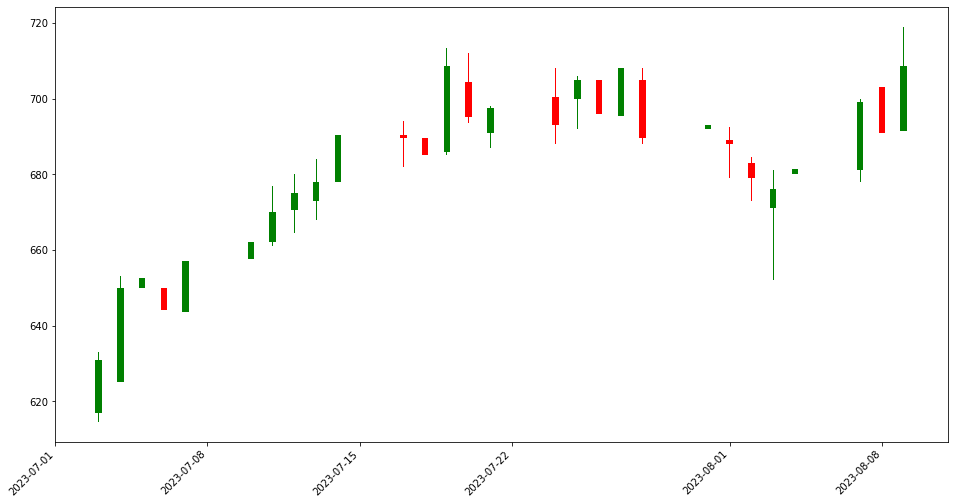

In [525]:
r = data.loc['2023-07-01':'2023-08-09']
up = r[r.close >= r.open]
down = r[r.close < r.open]


width = .3
width2 = .03

plt.figure(figsize = (16,8))

col1 = "green"
col2 = "red"

plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)

plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)

plt.xticks(rotation=45, ha='right')

plt.show()
